
# pPXF: Fitting multiple stellar kinematic components

![pPXF](https://www-astro.physics.ox.ac.uk/~cappellari/software/ppxf_logo.svg)

## Description

Usage example for the procedure pPXF originally described in 
[Cappellari & Emsellem (2004)](http://adsabs.harvard.edu/abs/2004PASP..116..138C),
substantially upgraded in 
[Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C) 
and with the inclusion of photometry and linear constraints in 
[Cappellari (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C).

This example shows how to fit multiple stellar components with different
stellar population and kinematics.

### MODIFICATION HISTORY

- V1.0.0: Early test version. Michele Cappellari, Oxford, 20 July 2009
- V1.1.0: Cleaned up for the paper by Johnston et al. (MNRAS, 2013).
      MC, Oxford, 26 January 2012
- V2.0.0: Converted to Python and adapted to the changes in the new public
      PPXF version, Oxford 8 January 2014
- V2.0.1: Support both Python 2.6/2.7 and Python 3.x. MC, Oxford, 25 May 2014
- V2.0.2: Support both Pyfits and Astropy to read FITS files.
      MC, Oxford, 22 October 2015
- V2.0.3: Use proper noise in input. MC, Oxford, 8 March 2016
- V2.1.0: Replaced the Vazdekis-99 SSP models with the Vazdekis+10 ones.
      MC, Oxford, 3 May 2016
- V2.1.1: Make files paths relative to this file, to run the example from
      any directory. MC, Oxford, 18 January 2017
- V2.1.2: Updated MILES file names. MC, Oxford, 29 November 2017
- V2.1.3: Changed imports for pPXF as a package.
      Make file paths relative to the pPXF package to be able to run the
      example unchanged from any directory. MC, Oxford, 17 April 2018
- V2.1.4: Dropped legacy Python 2.7 support. MC, Oxford, 10 May 2018
- V2.1.5: Fixed clock DeprecationWarning in Python 3.7.
      MC, Oxford, 27 September 2018
- V2.2.0: Illustrates the usage of the `constr_kinem` keyword.
      MC, Oxford, 5 February 2020
- V2.3.0: Modified usage example of the `constr_kinem` keyword.
      MC, Oxford, 21 December 2020
- V2.4.0: Use E-Miles spectral library. MC, Oxford, 16 March 2022
- V2.5.0: Use the new `sps_util` instead of `miles_util`. 
      MC, Oxford, 12 November 2023
___

In [1]:
from pathlib import Path
from time import perf_counter as clock
from urllib import request

from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib

## Creation of the mock spectrum

In [2]:
lam_range_temp = [3500, 7500]
sps_name = 'emiles'
velscale = 35   # km/s

Read SPS models file from my GitHub if not already in the `pPXF` package dir.
The SPS model files are also available on my [GitHub Page](https://github.com/micappe/ppxf_data).

In [3]:
ppxf_dir = Path(util.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

In [4]:
sps = lib.sps_lib(filename, velscale, wave_range=lam_range_temp)

Extract two SPS templates, one is young and the other is old

In [5]:
model1 = sps.templates[:, -2, -2]  # age = 12.59 Gyr [M/H] = 0
model2 = sps.templates[:, 12, -2]  # age = 1.0 Gyr [M/H] = 0
model1 /= np.median(model1)
model2 /= np.median(model2)

In [6]:
model = np.column_stack([model1, model2])
galaxy = np.empty_like(model)

These are the input values in spectral pixels for the `(V, sigma)` of the two
kinematic components

In [7]:
vel = np.array([0., 300.])/velscale
sigma = np.array([200., 100.])/velscale

The synthetic galaxy model consists of the sum of two SSP spectra with age of
1Gyr and 13Gyr respectively with different velocity and dispersion

In [8]:
for j in range(len(vel)):
    dx = int(abs(vel[j]) + 4.*sigma[j])   # Sample the Gaussian at least to vel+4*sigma
    v = np.linspace(-dx, dx, 2*dx + 1)
    losvd = np.exp(-0.5*((v - vel[j])/sigma[j])**2) # Gaussian LOSVD
    losvd /= np.sum(losvd)      # normalize LOSVD
    galaxy[:, j] = signal.fftconvolve(model[:, j], losvd, mode="same")
    galaxy[:, j] /= np.median(model[:, j])
galaxy = np.sum(galaxy, axis=1)
sn = 100.
noise = np.full_like(galaxy, np.median(galaxy)/sn)
prng = np.random.default_rng(123)  # For reproducible results
galaxy = prng.normal(galaxy, noise) # add noise to galaxy

## pPXF fitting

For simplicity of illustration, I adopt two templates per kinematic
component. In a real situation, I may determine the two templates by fitting
the galaxy spectra in regions where I expect one of the two components to
provide negligible contribution to the surface brightness.

In [9]:
templates = np.column_stack([model1, model2, model1, model2])
goodpixels = np.arange(100, model1.size - 100)  # Remove edge effects

With multiple stellar kinematic components a good starting velocity is
essential. Starting too far from the solution pPXF may *not* converge to the
global minimum. One should give different starting velocities for the two
stellar components. In general one should explore a grid of starting
velocities as illustrated e.g. in Sec.3.3 of 
[Mitzkus et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017MNRAS.464.4789M)
or use the `global_search` keyword to perform global optimization and ensure
convergence to the global minimum.

In [10]:
start = [[100, 200], [200, 200]]

In [11]:
print(f"\n{'#'*60}\n{'No constraints on the kinematics'.center(60)}\n{'-'*60}")
t = clock()
pp = ppxf(templates, galaxy, noise, velscale, start, goodpixels=goodpixels,
          degree=4, moments=[2, 2], component=[0, 0, 1, 1], 
          lam=sps.lam_temp, lam_temp=sps.lam_temp)
print(f"{'='*60}\nElapsed time in pPXF {clock() - t:.2f} s")


############################################################
              No constraints on the kinematics              
------------------------------------------------------------
 Best Fit:       Vel     sigma
 comp.  0:        -2       197
 comp.  1:       302       101
chi2/DOF: 1.003; DOF: 6324; degree = 4; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 29; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/4
Templates weights:
     0.988         0         0      1.01
Elapsed time in pPXF 0.38 s


Text(0.5, 1.0, 'Two components pPXF fit')

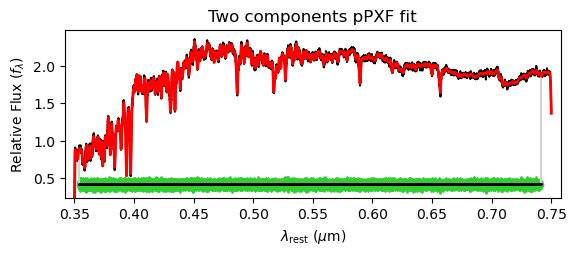

In [12]:
plt.clf()
plt.subplot(211)
pp.plot()
plt.title("Two components pPXF fit")

Just to illustrate how to use `constr_kinem`, here I constrain the two sigmas
to be within 50% of each other: `1/1.5 <= sigma[1]/sigma[0] <= 1.5`. The best
fit is at the boundary of the feasible region.

In [13]:
A_ineq = [[0, 1/1.5, 0, -1],    # sigma0/1.5 - sigma1 <= 0
          [0,  -1.5, 0,  1]]    # -sigma0*1.5 + sigma1 <= 0
b_ineq = [0, 0]
constr_kinem = {"A_ineq": A_ineq, "b_ineq": b_ineq}

In [14]:
print(f"\n{'#'*60}\n{'Constraint: sigma[0]/1.5 <= sigma[1] <= sigma[0]*1.5'.center(60)}\n{'-'*60}")
t = clock()
pp = ppxf(templates, galaxy, noise, velscale, start,
          goodpixels=goodpixels, degree=4, moments=[2, 2],
          component=[0, 0, 1, 1], constr_kinem=constr_kinem,
          lam=sps.lam_temp, lam_temp=sps.lam_temp)
print(f"{'='*60}\nElapsed time in pPXF {clock() - t:.2f} s")


############################################################
    Constraint: sigma[0]/1.5 <= sigma[1] <= sigma[0]*1.5    
------------------------------------------------------------
 Best Fit:       Vel     sigma
 comp.  0:       -41       165
 comp.  1:       295       110
chi2/DOF: 1.015; DOF: 6324; degree = 4; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 34; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/4
Templates weights:
     0.825         0     0.158      1.01
Elapsed time in pPXF 0.40 s


This is a fit with a single kinematic component, for reference.

In [15]:
start = [100, 200]
print(f"\n{'#'*60}\n{'Single component pPXF fit'.center(60)}\n{'-'*60}")
pp = ppxf(templates, galaxy, noise, velscale, start,
          goodpixels=goodpixels, degree=4, moments=2,
          lam=sps.lam_temp, lam_temp=sps.lam_temp)
print(f"{'='*60}\nElapsed time in pPXF {clock() - t:.2f} s")


############################################################
                 Single component pPXF fit                  
------------------------------------------------------------
 Best Fit:       Vel     sigma
 comp.  0:       198       218
chi2/DOF: 2.092; DOF: 6326; degree = 4; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/4
Templates weights:
     0.477     0.514     0.477     0.514
Elapsed time in pPXF 0.54 s


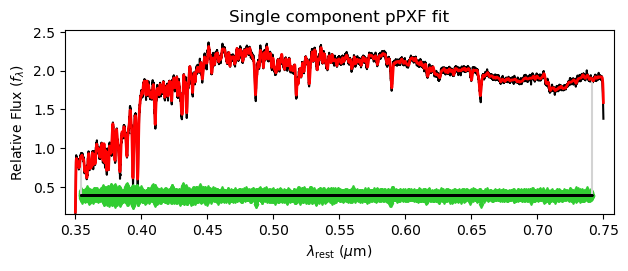

In [16]:
plt.subplot(212)
pp.plot()
plt.title("Single component pPXF fit")
plt.tight_layout()
plt.pause(5);